need to use colab for gpus

1. Setup and Load Data

1.1 Install Dependencies and Setup

In [30]:
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import torchvision.models.segmentation
import torch
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import scipy.io
from sklearn.model_selection import train_test_split
import random
from torchviz import make_dot
import torch.optim as optim
from torchsummary import summary

# Set the device to use
# CUDA refers to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 50
batch_size = 256

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# If you are on CoLab and successfully using the GPU, this print should
#   contain "cuda" in it
print(str(device))
assert('cuda' in str(device))  # comment out this assert if you are not using a GPU

torch.cuda.empty_cache()

cuda:0


In [31]:
import tqdm

image_list = []
theta_list = []

image_directory = 'image_gray'
value_directory = 'value_gray/'

# i = 0

# iterate over files in
# that directory
for filename in tqdm.tqdm(os.listdir(image_directory)):
    # print(filename)
    f = os.path.join(image_directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        # Opens a image
        # image = Image.open(f)
        # data = np.asarray(image)

        data = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2GRAY)
        data = cv2.resize(data, (128,128), interpolation=cv2.INTER_CUBIC)
        data = np.expand_dims(data, axis=2)

        matfile = value_directory + filename[:len(filename) - 4] + '.mat'
        mat = scipy.io.loadmat(matfile)
        image_list.append(data)
        theta_list.append(mat['th0'][0])
        # i += 1
        # if i > 200:
        #     break

print(image_list[0].shape)
print(theta_list[0])

theta_list = np.asarray(theta_list)
image_list = np.asarray(image_list)

image_list = np.moveaxis(image_list, -1, 1)
theta_list = np.moveaxis(theta_list, -1, 1)

# print(theta_list)

print(image_list.shape)

# image_train, image_test, theta_train, theta_test = train_test_split(image_list, theta_list)

# print(image_train.shape)

image_list = torch.tensor(image_list).float()
# print(image_list)
theta_list = torch.tensor(theta_list)
print(theta_list)

# image_list.shape

100%|██████████| 1109/1109 [00:08<00:00, 127.67it/s]

(128, 128, 1)
[2.31746029e+06 4.93180207e-01 4.43140000e+04]
(1109, 1, 128, 128)
tensor([[2.3175e+06, 4.9318e-01, 4.4314e+04],
        [1.3460e+06, 1.9971e+00, 6.3100e+03],
        [1.5866e+06, 2.4906e+00, 4.0160e+03],
        ...,
        [3.4765e+06, 6.2094e-01, 4.0990e+03],
        [1.0007e+06, 1.7644e+00, 2.5561e+04],
        [1.6117e+06, 3.2764e-01, 4.1340e+03]], dtype=torch.float64)


In [32]:
# normalize data:

# images
imean = torch.std(image_list, dim=0)
istd = torch.mean(image_list, dim=0)
# image_tensor = torch.div(torch.sub(image_list, imean), istd)
image_tensor = torch.div(image_list, 255).float()
print(image_tensor)

# theta
tmean = torch.std(theta_list, dim=0)
tstd = torch.mean(theta_list, dim=0)
theta_tensor = torch.div(torch.sub(theta_list, tmean), tstd).float()
print(theta_tensor)

tensor([[[[0.2353, 0.2353, 0.3451,  ..., 0.5451, 0.6157, 0.6157],
          [0.2353, 0.2353, 0.3451,  ..., 0.5451, 0.6157, 0.6157],
          [0.2980, 0.2980, 0.3098,  ..., 0.5725, 0.5412, 0.5412],
          ...,
          [0.4824, 0.4824, 0.3922,  ..., 0.3059, 0.2784, 0.2784],
          [0.4745, 0.4745, 0.3922,  ..., 0.3059, 0.2824, 0.2824],
          [0.4745, 0.4745, 0.3922,  ..., 0.3059, 0.2824, 0.2824]]],


        [[[0.3961, 0.4627, 0.4471,  ..., 0.3843, 0.4667, 0.5059],
          [0.5922, 0.6118, 0.3725,  ..., 0.4275, 0.3882, 0.4902],
          [0.5059, 0.4902, 0.3882,  ..., 0.4431, 0.4431, 0.4902],
          ...,
          [0.6667, 0.8078, 0.7373,  ..., 0.6824, 0.6824, 0.7922],
          [0.6980, 0.7294, 0.6392,  ..., 0.5451, 0.4745, 0.6157],
          [0.6000, 0.6314, 0.5294,  ..., 0.5216, 0.5373, 0.6824]]],


        [[[0.5686, 0.5529, 0.5529,  ..., 0.5059, 0.5098, 0.4431],
          [0.6706, 0.4745, 0.4863,  ..., 0.4078, 0.4039, 0.4431],
          [0.6667, 0.4784, 0.4902,  ..

In [33]:
image_train, image_test, theta_train, theta_test = train_test_split(image_tensor, theta_tensor)

In [34]:
train_dataset = TensorDataset(image_train, theta_train)
print(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)
print(train_loader)

test_dataset = TensorDataset(image_test, theta_test)
print(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
print(test_loader)

In [35]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2) 
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding=2) 
        self.pool3 = nn.MaxPool2d(2, 2)

        self.size_linear = 128*16*16
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)


    def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x))) 
            x = self.pool2(F.relu(self.conv2(x))) 
            x = self.pool3(F.relu(self.conv3(x)))
            x = x.view(-1, self.size_linear) # this flattens x into a 1D vector
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x)) 
            x = self.fc3(x)
            return x

In [36]:
##ASSERT: checks if CNN has the correct output shape
with torch.no_grad():  # tells PyTorch not to track gradients here
    # test_data is 100 random images, 3 channel2, 128-by-128
    test_data = torch.rand(100,1,128,128)
    test_net = ConvNet()
    out = test_net.forward(test_data)
    # the output should have size (100,3)
    print(out)
    print(out.size())
    assert(out.size()==(100,3))

    print(out[0][0])

tensor([[ 0.0476, -0.0079,  0.0839],
        [ 0.0483, -0.0089,  0.0853],
        [ 0.0486, -0.0098,  0.0848],
        [ 0.0469, -0.0095,  0.0872],
        [ 0.0502, -0.0092,  0.0862],
        [ 0.0488, -0.0096,  0.0851],
        [ 0.0486, -0.0093,  0.0853],
        [ 0.0480, -0.0108,  0.0834],
        [ 0.0474, -0.0094,  0.0844],
        [ 0.0475, -0.0104,  0.0847],
        [ 0.0490, -0.0089,  0.0844],
        [ 0.0472, -0.0099,  0.0831],
        [ 0.0484, -0.0088,  0.0848],
        [ 0.0471, -0.0084,  0.0850],
        [ 0.0482, -0.0098,  0.0860],
        [ 0.0482, -0.0095,  0.0855],
        [ 0.0484, -0.0090,  0.0849],
        [ 0.0486, -0.0097,  0.0839],
        [ 0.0483, -0.0083,  0.0859],
        [ 0.0483, -0.0086,  0.0852],
        [ 0.0476, -0.0090,  0.0850],
        [ 0.0478, -0.0094,  0.0858],
        [ 0.0489, -0.0084,  0.0854],
        [ 0.0482, -0.0098,  0.0841],
        [ 0.0473, -0.0097,  0.0860],
        [ 0.0486, -0.0094,  0.0842],
        [ 0.0484, -0.0087,  0.0853],
 

In [37]:
class Trainer():
    def __init__(self,net=None,optim=None,loss_function=None, train_loader=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function
        self.train_loader = train_loader

    def train(self,epochs):
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_steps = 0
            for data in self.train_loader:
                
                # Moving this batch to GPU
                # Note that X has shape (batch_size, number of channels, height, width)
                # which is equal to (256,3,128,128) since our default batch_size = 256 and 
                # the image has only 1 channel
                X = data[0].to(device)
                y = data[1].to(device)
                
                # print(X[0])
                # plt.imshow(np.moveaxis(X[0].cpu().numpy(), 0, -1))

                
                # Zero the gradient in the optimizer i.e. self.optim
                self.optim.zero_grad()

                # Getting the output of the Network
                out = self.net(X)

                # Computing loss using loss function i.e. self.loss_function
                loss = self.loss_function(out, y)

                # Backpropagate to compute gradients of parameteres
                loss.backward()

                # Call the optimizer i.e. self.optim
                self.optim.step()

                epoch_loss += loss.item()
                epoch_steps += 1
            # average loss of epoch
            losses.append(epoch_loss / epoch_steps)
            print("epoch [%d]: loss %.3f" % (epoch+1, losses[-1]))
        return losses

In [42]:
### try different learning rates for SGD to see which one works (do not try learning rates greater than 1)
### we want the last epoch loss to be less than 0.03
learning_rate = 0.0001 #ACT16

net = ConvNet()
net = net.to(device)
# opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
opt = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

trainer = Trainer(net=net, optim=opt, loss_function=loss_function, train_loader=train_loader)

losses = trainer.train(num_epochs)


epoch [1]: loss 0.362
epoch [2]: loss 0.267
epoch [3]: loss 0.250
epoch [4]: loss 0.240
epoch [5]: loss 0.225
epoch [6]: loss 0.207
epoch [7]: loss 0.188
epoch [8]: loss 0.162
epoch [9]: loss 0.137
epoch [10]: loss 0.115
epoch [11]: loss 0.093
epoch [12]: loss 0.080
epoch [13]: loss 0.065
epoch [14]: loss 0.058
epoch [15]: loss 0.050
epoch [16]: loss 0.048
epoch [17]: loss 0.042
epoch [18]: loss 0.035
epoch [19]: loss 0.032
epoch [20]: loss 0.024
epoch [21]: loss 0.025
epoch [22]: loss 0.023
epoch [23]: loss 0.021
epoch [24]: loss 0.022
epoch [25]: loss 0.022
epoch [26]: loss 0.022
epoch [27]: loss 0.020
epoch [28]: loss 0.016
epoch [29]: loss 0.015
epoch [30]: loss 0.015
epoch [31]: loss 0.014
epoch [32]: loss 0.012
epoch [33]: loss 0.015
epoch [34]: loss 0.016
epoch [35]: loss 0.015
epoch [36]: loss 0.014
epoch [37]: loss 0.013
epoch [38]: loss 0.015
epoch [39]: loss 0.017
epoch [40]: loss 0.014
epoch [41]: loss 0.012
epoch [42]: loss 0.009
epoch [43]: loss 0.007
epoch [44]: loss 0.0

Text(0, 0.5, 'training loss')

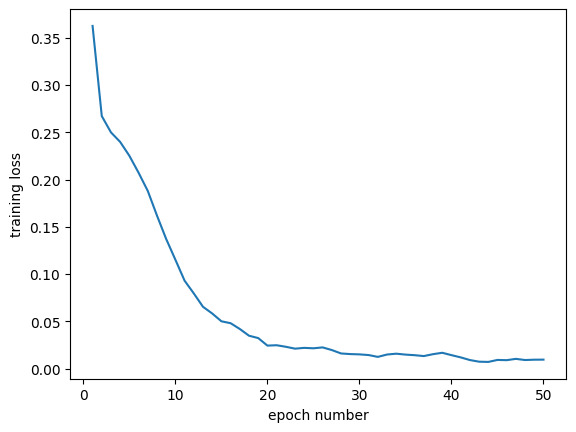

In [43]:
import matplotlib.pyplot as plt
### plot the training loss (y-axis) vs epoch number (x-axis)
### using the losses computed
plt.plot(range(1,num_epochs+1), losses)
plt.xlabel("epoch number")
plt.ylabel("training loss")

In [40]:
err1 = 0
err2 = 0
err3 = 0
tot = 0
with torch.no_grad():
    for data in test_loader:
        # retrieve X and y for this batch, from data, and 
        # move it to the device you are using (probably the GPU)
        X = data[0].to(device)
        y = data[1].to(device)

        # raw output of network for X
        output = net(X)

        print("###################################################")
        print(torch.add(torch.mul(output[0], tstd.to(device)), tmean.to(device)))
        print(torch.add(torch.mul(y[0], tstd.to(device)), tmean.to(device)))
        print("###################################################")
        
        # let the maximum index be our predicted class
        # _, yh = torch.max(output, 1) 

        # tot will 10,000 at the end, total number of test data
        tot += y.size(0)

        ## add to err number of missclassification, i.e. number of indices that 
        ## yh and y are not equal
        ## note that y and yh are vectors of size = batch_size = (256 in our case)
        # err += (y != yh).sum()

        errors = output.sub(y).multiply(output.sub(y)).div(batch_size).sum(axis=0)
        err1 += errors[0]
        err2 += errors[1]
        err3 += errors[2]

print(tot)
print(err1)
print(err2)
print(err3)

print('Accuracy of prediction on test (1): %5.2f%%' % (100-100 * err1 / tot))

print('Accuracy of prediction on test (2): %5.2f%%' % (100-100 * err2 / tot))

print('Accuracy of prediction on test (3): %5.2f%%' % (100-100 * err3 / tot))

###ASSERTS
# assert((100-100 * err / tot)>=98)
# assert(tot==10*1000)

###################################################
tensor([2.6854e+06, 8.5872e-01, 1.3908e+04], device='cuda:0',
       dtype=torch.float64)
tensor([1.4904e+06, 1.7791e+00, 8.8790e+03], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([2.6444e+06, 1.5198e+00, 9.1182e+03], device='cuda:0',
       dtype=torch.float64)
tensor([3.9179e+06, 2.5497e+00, 1.2114e+04], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([2.9095e+06, 1.9100e+00, 7.3091e+03], device='cuda:0',
       dtype=torch.float64)
tensor([1.1752e+06, 4.5115e-02, 4.6090e+03], device='cuda:0',
       dtype=torch.float64)
###################################################
###################################################
tensor([2.9359e+06, 1.3726e+00, 1.2410e+04], device='cuda:0',
       dtype=torch.float64)
tensor